# Análisis Comparativo de Modelos SVM y CNN para Clasificación de Imágenes con Explicabilidad mediante Grad-CAM

- Integrantes: Felipe Peralta, Samantha Suquilanda

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

## Rutas del dataset y selección de clases

In [9]:
base_dir = '../data/fruits-360_100x100/fruits-360'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

classes_to_use = ['Apple Red 1', 'Banana 1', 'Limes 1', 'Strawberry 1', 'Cherimoya 1', 'Cucumber 1', 'Ginger 2', 'Mango 1', 'Nut 1', 'Peach 1', 'Papaya 1', 'Orange 1']
print(f"Clases seleccionadas: {classes_to_use}")

Clases seleccionadas: ['Apple Red 1', 'Banana 1', 'Limes 1', 'Strawberry 1', 'Cherimoya 1', 'Cucumber 1', 'Ginger 2', 'Mango 1', 'Nut 1', 'Peach 1', 'Papaya 1', 'Orange 1']


## Normalización

In [4]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

## Cargar los datos de entrenamiento y validación

In [10]:
# Cargar entrenamiento
print("Cargando imágenes de entrenamiento...")
train_generator = datagen.flow_from_directory(
    train_dir,                  
    target_size=(100, 100),     
    batch_size=32,              
    class_mode='categorical', 
    subset='training',          # Pedir la parte de entrenamiento
    classes=classes_to_use,     
    shuffle=True                
)

# Cargar validación
print("Cargando imágenes de validación...")
val_generator = datagen.flow_from_directory(
    train_dir,                
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation',        # Pedir la parte reservada para validar
    classes=classes_to_use,
    shuffle=True
)

Cargando imágenes de entrenamiento...
Found 4576 images belonging to 12 classes.
Cargando imágenes de validación...
Found 1140 images belonging to 12 classes.


## Verificación visual

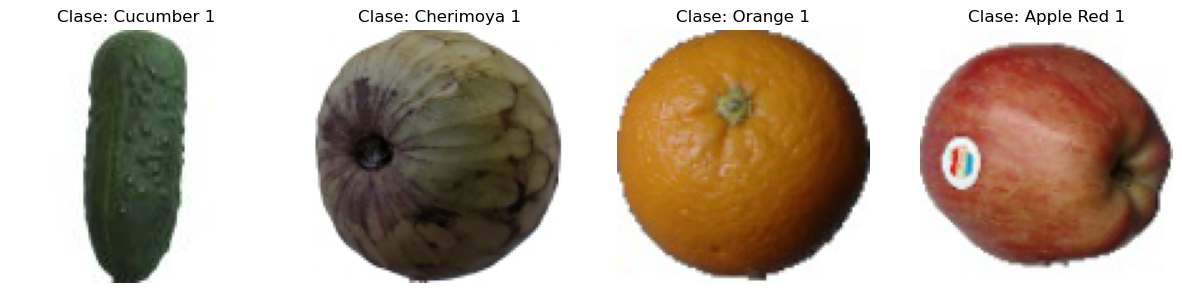

In [11]:
train_generator.reset()
x_batch, y_batch = train_generator[0]
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(x_batch[i])
    class_idx = np.argmax(y_batch[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    axes[i].set_title(f"Clase: {class_name}")
    axes[i].axis('off')
plt.show()

## SVM

### Convertir datos para SVM

In [7]:
def get_data_from_generator(generator):
    generator.reset()
    X_data, y_data = [], []
    
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        X_data.append(X_batch)
        y_data.append(y_batch)
        
    return np.concatenate(X_data), np.concatenate(y_data)

In [8]:
print("Convirtiendo datos para SVM...")
X_train, y_train_cat = get_data_from_generator(train_generator)
X_test, y_test_cat = get_data_from_generator(val_generator)

num_pixels = 100 * 100 * 3
X_train_flat = X_train.reshape(X_train.shape[0], num_pixels)
X_test_flat = X_test.reshape(X_test.shape[0], num_pixels)

y_train_indices = np.argmax(y_train_cat, axis=1)
y_test_indices = np.argmax(y_test_cat, axis=1)

print(f"Dimensiones para SVM: {X_train_flat.shape}")
print(f"Clases únicas en entrenamiento: {np.unique(y_train_indices)}")
print(f"Distribución de clases en train: {np.bincount(y_train_indices)}")
print(f"Clases únicas en test: {np.unique(y_test_indices)}")
print(f"Distribución de clases en test: {np.bincount(y_test_indices)}")

Convirtiendo datos para SVM...
Dimensiones para SVM: (4576, 30000)
Clases únicas en entrenamiento: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Distribución de clases en train: [394 392 392 394 778 120 349 392 193 394 394 384]
Clases únicas en test: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Distribución de clases en test: [ 98  98  98  98 194  30  87  98  48  98  98  95]


### Entrenamiento y evaluación del modelo SVM

In [9]:
print("Entrenando SVM...")

# Crear el modelo SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Entrenar
svm_model.fit(X_train_flat, y_train_indices)

Entrenando SVM...


,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [10]:
# Evaluar
y_pred_svm = svm_model.predict(X_test_flat)
print("--- Resultados SVM ---")
print(f"Accuracy: {accuracy_score(y_test_indices, y_pred_svm):.2f}")
print(classification_report(y_test_indices, y_pred_svm, target_names=classes_to_use))

--- Resultados SVM ---
Accuracy: 1.00
              precision    recall  f1-score   support

 Apple Red 1       1.00      1.00      1.00        98
    Banana 1       1.00      0.96      0.98        98
     Limes 1       1.00      1.00      1.00        98
Strawberry 1       1.00      1.00      1.00        98
 Cherimoya 1       1.00      1.00      1.00       194
  Cucumber 1       1.00      1.00      1.00        30
    Ginger 2       0.96      1.00      0.98        87
     Mango 1       1.00      1.00      1.00        98
       Nut 1       1.00      1.00      1.00        48
     Peach 1       1.00      1.00      1.00        98
    Papaya 1       1.00      1.00      1.00        98
    Orange 1       1.00      1.00      1.00        95

    accuracy                           1.00      1140
   macro avg       1.00      1.00      1.00      1140
weighted avg       1.00      1.00      1.00      1140



## CNN

### Construcción del modelo CNN

In [11]:
cnn_model = Sequential([
    # Capa Convolucional 1: Aprende bordes y colores simples
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2, 2),
    
    # Capa Convolucional 2: Aprende formas más complejas
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Capa Convolucional 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Aplanado y Capas Densas
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Ayuda a evitar el overfitting
    
    # Capa de Salida: Tantas neuronas como clases tengamos
    Dense(len(classes_to_use), activation='softmax')
])

### Compilación

In [12]:
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              


                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 128)               1638528   
                                                                 
 dropout (

### Entrenamiento

In [13]:
print("\nEntrenando CNN...")
history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Entrenando CNN...
Epoch 1/10
143/143 [==============================] - 20s 130ms/step - loss: 0.5170 - accuracy: 0.8197 - val_loss: 0.0544 - val_accuracy: 0.9833
Epoch 2/10
143/143 [==============================] - 22s 152ms/step - loss: 0.0675 - accuracy: 0.9781 - val_loss: 0.0229 - val_accuracy: 0.9904
Epoch 3/10
143/143 [==============================] - 21s 150ms/step - loss: 0.0267 - accuracy: 0.9904 - val_loss: 5.6266e-05 - val_accuracy: 1.0000
Epoch 4/10
143/143 [==============================] - 23s 158ms/step - loss: 0.0285 - accuracy: 0.9913 - val_loss: 0.0892 - val_accuracy: 0.9816
Epoch 5/10
143/143 [==============================] - 21s 149ms/step - loss: 0.0317 - accuracy: 0.9897 - val_loss: 0.0022 - val_accuracy: 0.9991
Epoch 6/10
143/143 [==============================] - 22s 152ms/step - loss: 0.0221 - accuracy: 0.9937 - val_loss: 0.0573 - val_accuracy: 0.9868
Epoch 7/10
143/143 [==============================] - 22s 153ms/step - loss: 0.0135 - accuracy: 0.9952 - va

### Visualización


Generando gráficas de rendimiento...


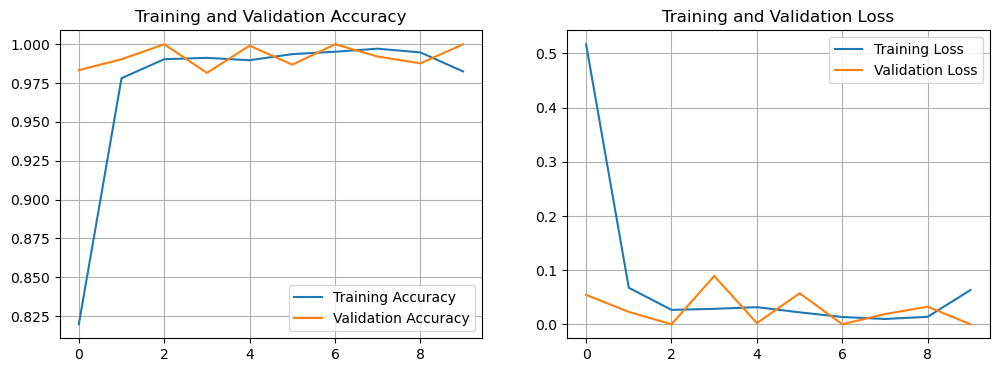

In [14]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Gráfica de Precisión (Accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # Gráfica de Pérdida (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    
    plt.show()

print("\nGenerando gráficas de rendimiento...")
plot_history(history)

Observaciones importantes:

- Training accuracy ≈ 1.0

- Validation accuracy ≈ 1.0

- Loss cercana a 0 tanto en entrenamiento como validación

Interpretación correcta:

- El modelo converge muy rápido

- No hay divergencia entre entrenamiento y validación

- No hay señales claras de overfitting

In [15]:
print("Generando predicciones de la CNN para comparar...")
preds_cnn = cnn_model.predict(X_test)
y_pred_cnn = np.argmax(preds_cnn, axis=1)

Generando predicciones de la CNN para comparar...
36/36 [==============================] - 2s 42ms/step


## Comparación de modelos

Comparación de Matrices de Confusión


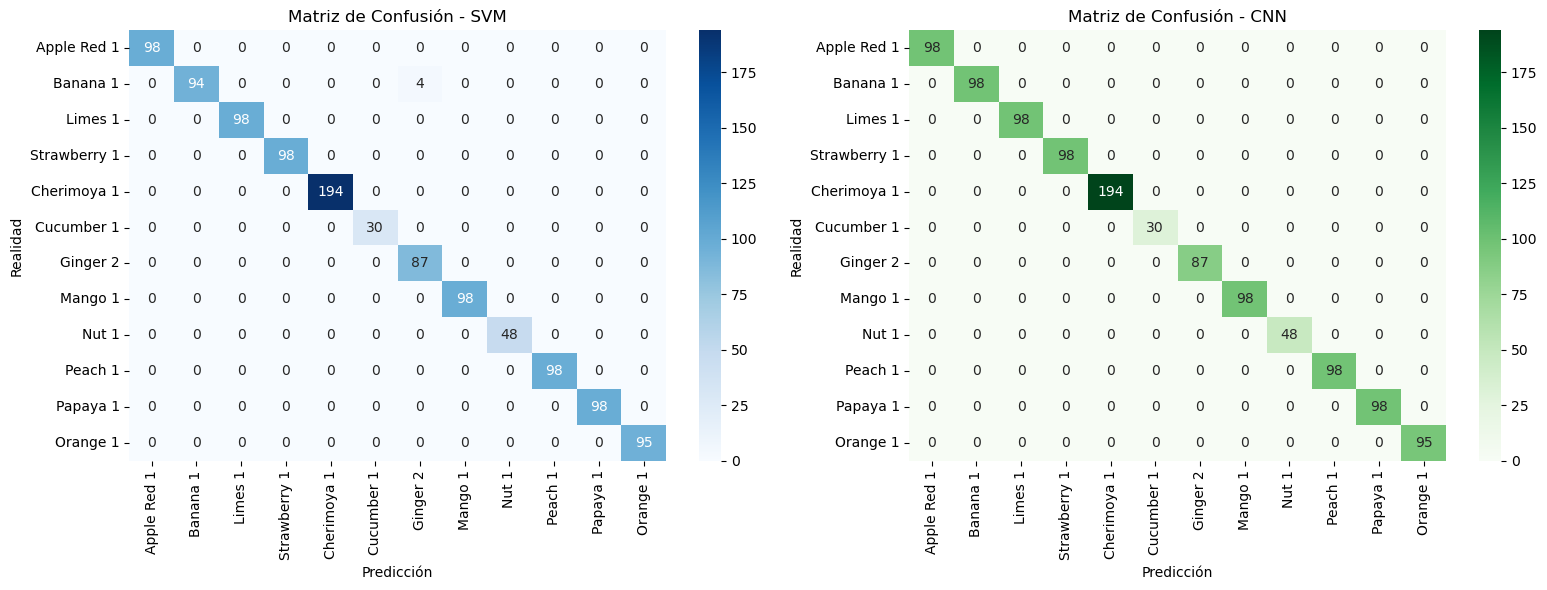

In [16]:
def plot_confusion_matrices(y_true, y_pred_svm, y_pred_cnn, classes):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Matriz SVM
    cm_svm = confusion_matrix(y_true, y_pred_svm)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=classes, yticklabels=classes)
    axes[0].set_title('Matriz de Confusión - SVM')
    axes[0].set_ylabel('Realidad')
    axes[0].set_xlabel('Predicción')

    # Matriz CNN
    cm_cnn = confusion_matrix(y_true, y_pred_cnn)
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
                xticklabels=classes, yticklabels=classes)
    axes[1].set_title('Matriz de Confusión - CNN')
    axes[1].set_ylabel('Realidad')
    axes[1].set_xlabel('Predicción')

    plt.tight_layout()
    plt.show()

print("Comparación de Matrices de Confusión")
plot_confusion_matrices(y_test_indices, y_pred_svm, y_pred_cnn, classes_to_use)

### Análisis:
- Diagonal casi perfecta en ambos modelos

- Muy pocos errores fuera de la diagonal

- La CNN tiene cero errores visibles

- El SVM tiene errores mínimos

Interpretación:

- Ambos modelos funcionan muy bien

- La CNN es ligeramente superior en robustez

- El SVM es más simple y rápido

Comparación de Métricas


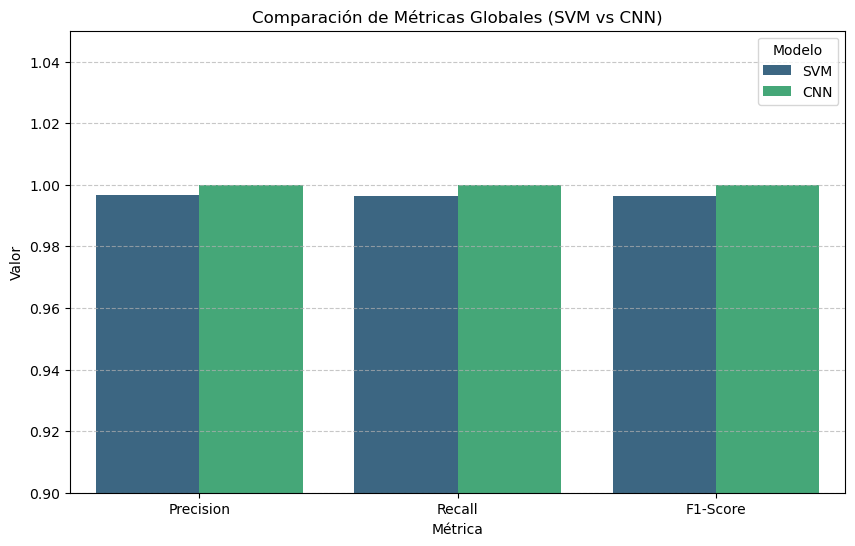

     Métrica     Valor Modelo
0  Precision  0.996645    SVM
1     Recall  0.996491    SVM
2   F1-Score  0.996494    SVM
3  Precision  1.000000    CNN
4     Recall  1.000000    CNN
5   F1-Score  1.000000    CNN


In [17]:
from sklearn.metrics import precision_recall_fscore_support

def plot_metrics_comparison(y_true, y_pred_svm, y_pred_cnn):
    # Calculamos métricas promedio (weighted)
    svm_metrics = precision_recall_fscore_support(y_true, y_pred_svm, average='weighted')
    cnn_metrics = precision_recall_fscore_support(y_true, y_pred_cnn, average='weighted')
    
    # Creamos un DataFrame para facilitar el plot
    metrics_df = pd.DataFrame({
        'Métrica': ['Precision', 'Recall', 'F1-Score', 'Precision', 'Recall', 'F1-Score'],
        'Valor': [svm_metrics[0], svm_metrics[1], svm_metrics[2], 
                  cnn_metrics[0], cnn_metrics[1], cnn_metrics[2]],
        'Modelo': ['SVM', 'SVM', 'SVM', 'CNN', 'CNN', 'CNN']
    })
    
    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_df, x='Métrica', y='Valor', hue='Modelo', palette="viridis")
    plt.ylim(0.9, 1.05) # Hacemos zoom en la parte superior porque tus modelos son muy buenos
    plt.title('Comparación de Métricas Globales (SVM vs CNN)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return metrics_df

print("Comparación de Métricas")
df_metrics = plot_metrics_comparison(y_test_indices, y_pred_svm, y_pred_cnn)
print(df_metrics)

### Análisis:
1. El SVM ofrece un excelente rendimiento con menor costo computacional.

2. La CNN alcanza el mejor desempeño global al aprender representaciones visuales profundas.

3. La diferencia se justifica por la capacidad de aprendizaje automático de características en CNN.

## Análisis de Explicabilidad (XAI) con Grad-CAM en CNN

In [18]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Guardar la activación original de la última capa
    last_layer = model.layers[-1]
    original_activation = last_layer.activation
    
    # Cambiar la activación a lineal para obtener los "logits"
    last_layer.activation = tf.keras.activations.linear
    
    # Construir el modelo de gradiente con la activación lineal
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Grabar el gradiente
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calcular el gradiente
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Global Average Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicar canales por importancia
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Restaurar la activación original del modelo
    last_layer.activation = original_activation

    # Normalización y limpieza
    heatmap = tf.maximum(heatmap, 0)
    max_heat = tf.math.reduce_max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap.numpy()

In [19]:
def predecir_y_explicar(ruta_imagen, model, classes):
    img = tf.keras.preprocessing.image.load_img(ruta_imagen, target_size=(100, 100))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    preds = model.predict(img_array)
    idx_pred = np.argmax(preds[0])
    label_pred = classes[idx_pred]
    confianza = preds[0][idx_pred]

    print(f"Predicción: {label_pred} ({confianza*100:.2f}%)")

    # Generar el heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    # Visualización
    heatmap_resized = cv2.resize(heatmap, (100, 100))
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    
    img_original_uint8 = np.uint8(255 * img_array[0])
    
    # Superposición
    superimposed_img = cv2.addWeighted(img_original_uint8, 0.6, heatmap_colored, 0.4, 0)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_array[0])
    ax[0].set_title("Imagen Original")
    
    # Mostrar el heatmap
    ax[1].imshow(heatmap, cmap='jet')
    ax[1].set_title("Activación (Raw)")
    
    ax[2].imshow(superimposed_img)
    ax[2].set_title(f"Explicación: {label_pred}")
    plt.show()

In [20]:
def get_last_conv_layer_name(model):
    # Buscar la última capa convolucional para conectar el Grad-CAM
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    raise ValueError("No se encontró capa convolucional")

last_conv_layer = get_last_conv_layer_name(cnn_model)
print(f"Capa Convolucional detectada para análisis: {last_conv_layer}")

Capa Convolucional detectada para análisis: conv2d_2


## Ejecución de casos de prueba

Caso 1: Banana
1/1 [==============================] - 0s 26ms/step
Predicción: Banana 1 (100.00%)


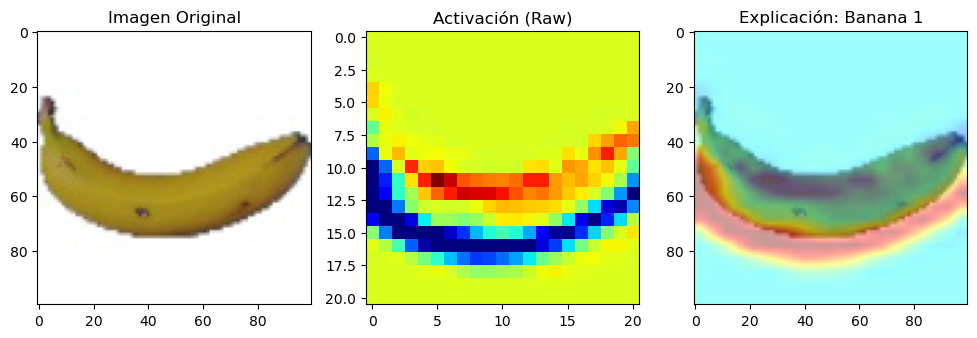

In [21]:
# CASO 1: Banana
print("Caso 1: Banana")
ruta_caso1 = "./data/fruits-360_100x100/fruits-360/Test/Banana 1/100_100.jpg"
if not os.path.exists(ruta_caso1):
    print(f"No se encontró la imagen en {ruta_caso1}")
else:
    predecir_y_explicar(ruta_caso1, cnn_model, classes_to_use)

Caso 2: Fresa
1/1 [==============================] - 0s 22ms/step
Predicción: Strawberry 1 (100.00%)


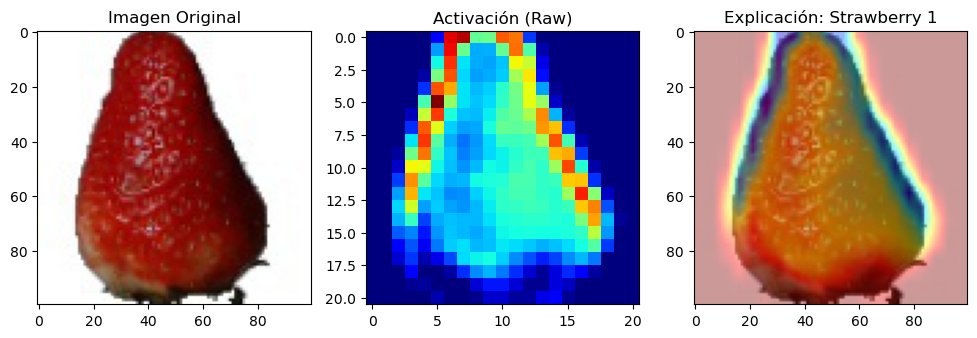

In [22]:
# CASO 2: Fresa
print("Caso 2: Fresa")
ruta_caso2 = "./data/fruits-360_100x100/fruits-360/Test/Strawberry 1/45_100.jpg"
if not os.path.exists(ruta_caso2):
    print(f"No se encontró la imagen en {ruta_caso2}")
else:
    predecir_y_explicar(ruta_caso2, cnn_model, classes_to_use)

## Resultados y análisis de modelos



Se entrenaron dos modelos de aprendizaje supervisado para clasificación de imágenes: una Máquina de Soporte Vectorial (SVM) y una Red Neuronal Convolucional (CNN), utilizando un subconjunto balanceado de un dataset de frutas con 12 clases.

El modelo SVM, configurado con kernel lineal, obtuvo valores de precisión, recall y F1-score cercanos a 0.996, evidenciando una adecuada separación de clases a partir de las características extraídas de las imágenes, con bajo costo computacional y tiempos de entrenamiento reducidos.

Por su parte, la CNN alcanzó un desempeño superior, logrando métricas de clasificación cercanas a 1.0. Esto se debe a su capacidad para aprender automáticamente patrones visuales relevantes como bordes, texturas y formas, lo que le permite una mayor robustez frente a variaciones visuales.

Los resultados obtenidos confirman que ambos modelos son efectivos para el problema planteado, con ventajas diferenciadas en términos de precisión y complejidad computacional.

## Justificación de predicciones

Para justificar las predicciones realizadas por los modelos, se emplearon matrices de confusión y métricas de evaluación globales, lo que permitió analizar el comportamiento de cada clase y detectar posibles errores de clasificación.

Adicionalmente, en el caso de la CNN, se utilizaron mapas de activación y visualizaciones de calor para explicar las decisiones del modelo. Estas visualizaciones muestran que la red se enfoca en regiones relevantes de la imagen, como la forma y textura del objeto, al momento de realizar la predicción.

## Conclusiones
Los resultados obtenidos demuestran que tanto SVM como CNN son modelos adecuados para la clasificación de imágenes, alcanzando altos niveles de desempeño en el conjunto de datos utilizado.

El SVM se destaca por su simplicidad y eficiencia computacional, mientras que la CNN ofrece una mayor capacidad de aprendizaje y robustez al trabajar directamente sobre las imágenes.

La alta precisión alcanzada se explica por la claridad visual de las clases seleccionadas y el uso de un subconjunto representativo del dataset, lo cual es suficiente para cumplir los objetivos de la práctica y realizar una comparación válida entre los modelos.